In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


# Import the libraries required

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import string
from nltk.corpus import stopwords
import gensim
from gensim import parsing
from wordcloud import WordCloud,STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text,sequence
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional

In [5]:
real_data=pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
fake_data=pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')

In [6]:
real_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [8]:
real_data['target']=1
fake_data['target']=0

In [9]:
real_data.tail()

,title,text,subject,date,target
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",1


In [10]:
fake_data.tail()

,title,text,subject,date,target
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",0


In [11]:
#merging fake and real data
data=pd.concat([real_data,fake_data])

In [12]:
data.head(10)

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017",1
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017",1
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017",1
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017",1
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017",1


In [13]:
data.tail(10)

,title,text,subject,date,target
23471,Seven Iranians freed in the prisoner swap have...,"21st Century Wire says This week, the historic...",Middle-east,"January 20, 2016",0
23472,#Hashtag Hell & The Fake Left,By Dady Chery and Gilbert MercierAll writers ...,Middle-east,"January 19, 2016",0
23473,Astroturfing: Journalist Reveals Brainwashing ...,Vic Bishop Waking TimesOur reality is carefull...,Middle-east,"January 19, 2016",0
23474,The New American Century: An Era of Fraud,Paul Craig RobertsIn the last years of the 20t...,Middle-east,"January 19, 2016",0
23475,Hillary Clinton: ‘Israel First’ (and no peace ...,Robert Fantina CounterpunchAlthough the United...,Middle-east,"January 18, 2016",0
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",0


In [14]:
data.isnull().sum()

title      0
text       0
subject    0
date       0
target     0
dtype: int64

Data contains no null value.

# Visualization

In [15]:
print(data['target'].value_counts())

0    23481
1    21417
Name: target, dtype: int64


Text(0.5, 1.0, 'Count of Real and Fake Data')

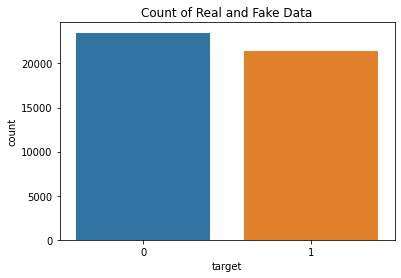

In [16]:
plot=sns.countplot(x='target', data=data)
plot.set_title('Count of Real and Fake Data')

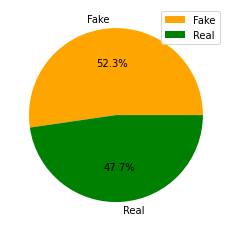

In [17]:
mylabels=["Fake", "Real"]
mycolors=['orange', 'green']
plt.pie(data['target'].value_counts(), labels=mylabels, colors=mycolors,autopct='%1.1f%%')
plt.legend()
plt.show()

In [18]:
print(data['subject'].value_counts())

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64


Text(0.5, 1.0, 'Distribution of subject according to real and fake data')

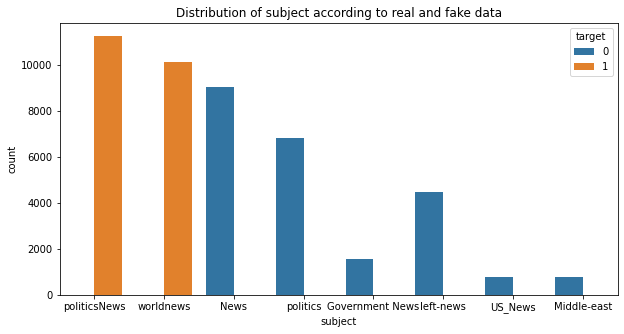

In [19]:
plt.figure(figsize=(10,5))
sns.countplot(x='subject', hue='target', data=data)
plt.title("Distribution of subject according to real and fake data")

# Data Cleaning

In [20]:
data.drop('title', inplace=True, axis=1)
data.drop('date', inplace=True, axis=1)
data.drop('subject', inplace=True, axis=1)

In [21]:
data.tail(10)

,text,target
23471,"21st Century Wire says This week, the historic...",0
23472,By Dady Chery and Gilbert MercierAll writers ...,0
23473,Vic Bishop Waking TimesOur reality is carefull...,0
23474,Paul Craig RobertsIn the last years of the 20t...,0
23475,Robert Fantina CounterpunchAlthough the United...,0
23476,21st Century Wire says As 21WIRE reported earl...,0
23477,21st Century Wire says It s a familiar theme. ...,0
23478,Patrick Henningsen 21st Century WireRemember ...,0
23479,21st Century Wire says Al Jazeera America will...,0
23480,21st Century Wire says As 21WIRE predicted in ...,0


# Data Preprocessing

In [22]:
def transformText(text):
  # All the necessary preprocessing on our text of choice
    stops = set(stopwords.words("english"))
  # Convert text to lower
    text = text.lower()
  # Removing non ASCII chars    
    text = re.sub(r'[^\x00-\x7f]',r' ',text) 
    text = re.sub('\[[^]]*\]', '', text)
    text= gensim.parsing.preprocessing.strip_non_alphanum(text)                       
  # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
  # Removing all the stopwords
    filtered_words = [word for word in text.split() if word not in stops]
  # Removing all the tokens with lesser than 3 characters
    filtered_words = gensim.corpora.textcorpus.remove_short(filtered_words, minsize=3)
  # Preprocessed text after stop words removal
    text = " ".join(filtered_words)
  # Remove the punctuation
    text = gensim.parsing.preprocessing.strip_punctuation2(text)
  # Strip all the numerics
    text = gensim.parsing.preprocessing.strip_numeric(text)
  # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
  # Stemming
    return gensim.parsing.preprocessing.stem_text(text)

In [23]:
data['text']=data['text'].apply(transformText)

In [24]:
data.head(20)

,text,target
0,washington reuter head conserv republican fact...,1
1,washington reuter transgend peopl allow first ...,1
2,washington reuter special counsel investig lin...,1
3,washington reuter trump campaign advis georg p...,1
4,seattl washington reuter presid donald trump c...,1
5,west palm beach fla washington reuter white ho...,1
6,west palm beach fla reuter presid donald trump...,1
7,follow statement post verifi twitter account p...,1
8,follow statement post verifi twitter account p...,1
9,washington reuter alabama secretari state john...,1


**A wordcloud is a visual reprsentation of text data. Words are usually single words, and the importance of each is shown with font size or color. Pyhton has a wordcloud library allowing to build them**

# WordCloud for Real News

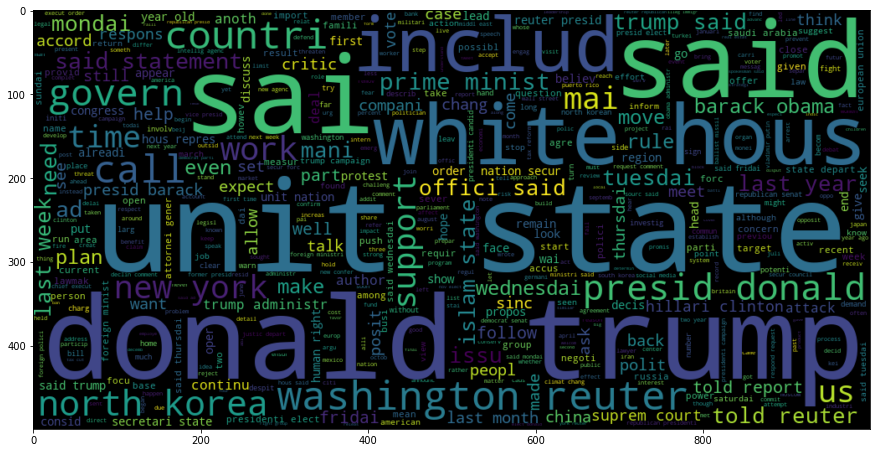

In [25]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data[data.target == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

# WordCloud for Fake News

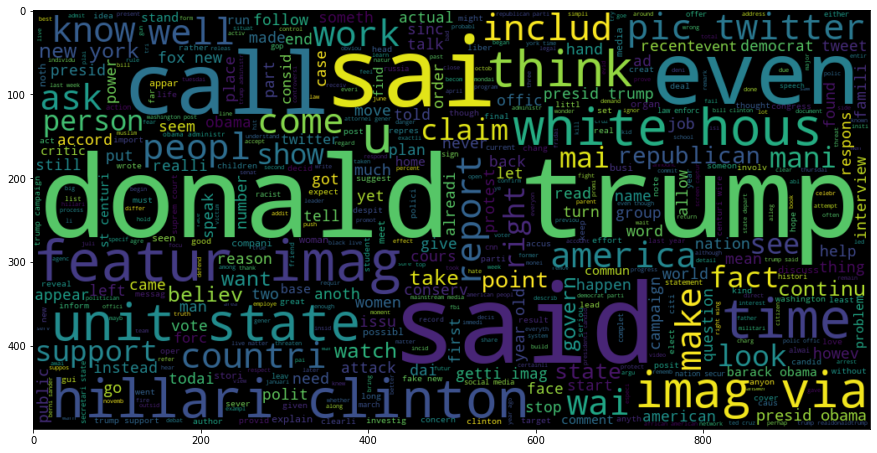

In [26]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data[data.target == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

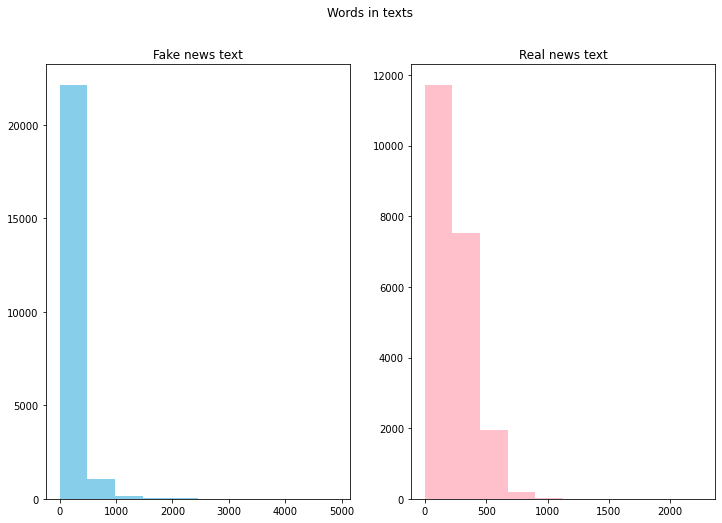

In [27]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=data[data['target']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='SkyBlue')
ax1.set_title('Fake news text')
text_len=data[data['target']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='pink')
ax2.set_title('Real news text')
fig.suptitle('Words in texts')
plt.show()

# N-Gram Analysis

In [28]:
texts=' '.join(data['text'])
words=texts.split(" ")

In [29]:
def draw_n_gram(words,i):
    n_gram=(pd.Series(nltk.ngrams(words,i)).value_counts())[:15]
    n_gram_df=pd.DataFrame(n_gram)
    n_gram_df=n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    print(n_gram_df.head())
    plt.figure(figsize = (16,9))
    return sns.barplot(x='count',y='word', data=n_gram_df)

# Unigram Analysis

        word   count
0   (trump,)  134660
1    (said,)  132823
2   (state,)   63362
3  (presid,)   60479
4   (would,)   55160


<AxesSubplot:xlabel='count', ylabel='word'>

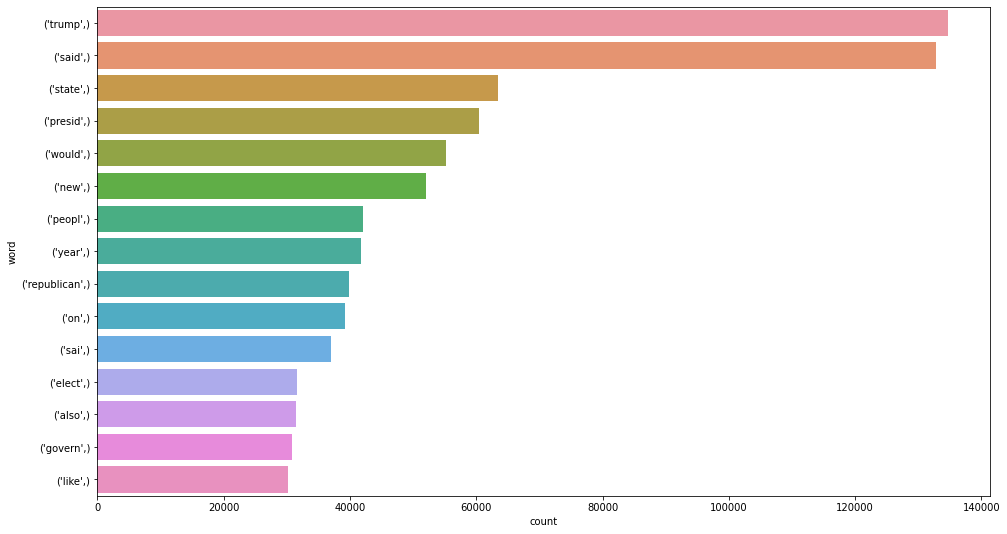

In [30]:
draw_n_gram(words,1)

# Bigram Analysis

                 word  count
0     (donald, trump)  26548
1       (unit, state)  18899
2       (white, hous)  15158
3  (hillari, clinton)   9765
4         (new, york)   9087


<AxesSubplot:xlabel='count', ylabel='word'>

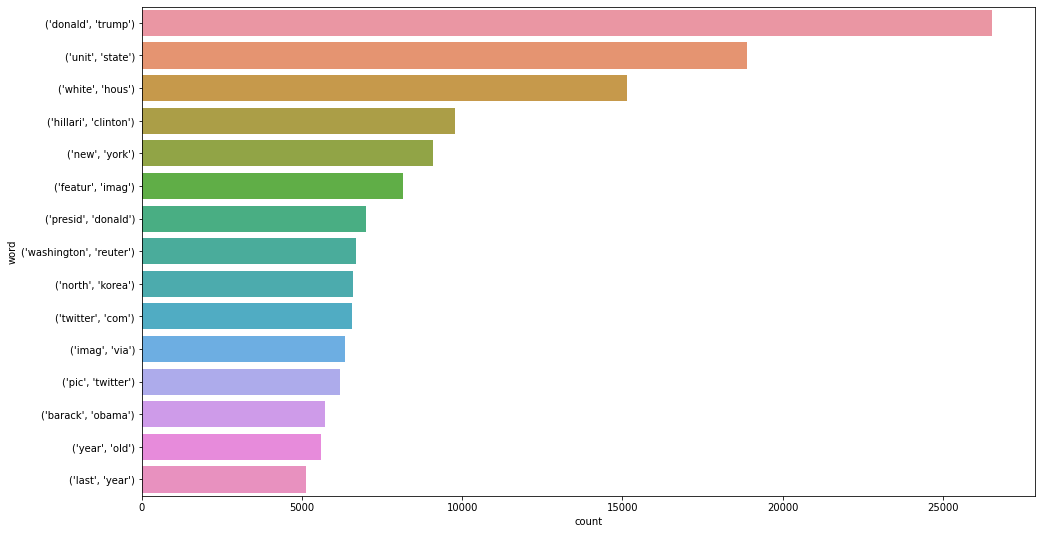

In [31]:
 draw_n_gram(words,2)

# Trigram Analysis

                      word  count
0  (presid, donald, trump)   6941
1      (pic, twitter, com)   6185
2      (featur, imag, via)   6088
3  (presid, barack, obama)   3918
4        (new, york, time)   2096


<AxesSubplot:xlabel='count', ylabel='word'>

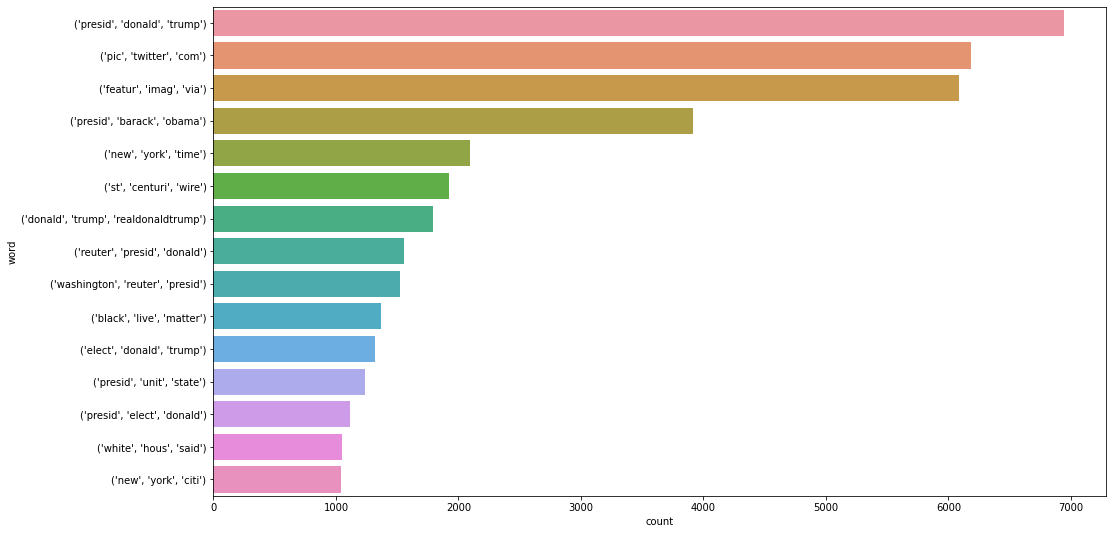

In [32]:
draw_n_gram(words,3)

**Done with Preprocessing, so we need to split the data into train and test**

In [33]:
X=data['text']
y=data['target']
X_train,X_test, y_train,y_test= train_test_split(X,y, test_size=0.20, random_state=1)

In [34]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(35918,)
(8980,)
(35918,)
(8980,)


# Feature Extraction with CountVectorizer and TfidfTransformer(Term Frequency-Inverse Document Frequency)

In [35]:
vectorizer=CountVectorizer()
transformer=TfidfTransformer()

**For Train Data**

In [36]:
X_train_vect=vectorizer.fit_transform(X_train)
X_train_tfidf=transformer.fit_transform(X_train_vect)

**For Test Data**

In [37]:
X_test_vect=vectorizer.transform(X_test)
X_test_tfidf=transformer.transform(X_test_vect)

# Classification with Logistic Regression

In [38]:
model=LogisticRegression()
model.fit(X_train_tfidf,y_train)
y_pred=model.predict(X_test_tfidf)
acc=accuracy_score(y_pred,y_test)
print(acc)

0.9841870824053452


# Training LSTM model(Long Short Term Memory)

In [40]:
# copnverting dependent variable into categorical variable
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [41]:
# converting to text to sequences
tokenizer=Tokenizer(20000,lower=True,oov_token='UNK')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [42]:
X_train = pad_sequences(X_train,maxlen=300,padding='post')
X_test = pad_sequences(X_test,maxlen=300,padding='post')

In [51]:
model_1 = Sequential()
model_1.add(Embedding(20000,64,input_length=300))
model_1.add(Dropout(0.5))
model_1.add(Bidirectional(LSTM(64,return_sequences=True)))
model_1.add(Bidirectional(LSTM(128)))
model_1.add(Dropout(0.3))
model_1.add(Dense(128))
model_1.add(Dense(2,activation="softmax"))

model_1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [52]:
print(model_1.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 64)           1280000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 300, 64)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 300, 128)          66048     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               263168    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

In [56]:
history = model_1.fit(X_train, y_train,epochs=5, batch_size=512, shuffle=True, verbose =1)

Epoch 1/5
71/71 [==============================] - 332s 5s/step - loss: 0.0014 - accuracy: 0.9995
Epoch 2/5
71/71 [==============================] - 332s 5s/step - loss: 0.0059 - accuracy: 0.9981
Epoch 3/5
71/71 [==============================] - 331s 5s/step - loss: 0.0020 - accuracy: 0.9993
Epoch 4/5
71/71 [==============================] - 332s 5s/step - loss: 7.8546e-04 - accuracy: 0.9998
Epoch 5/5
71/71 [==============================] - 339s 5s/step - loss: 0.0010 - accuracy: 0.9997


In [58]:
model_1.evaluate(X_test,y_test)

281/281 [==============================] - 69s 239ms/step - loss: 0.0220 - accuracy: 0.9958


[0.021995913237333298, 0.9957683682441711]

In [59]:
y_pred = model_1.predict(X_test)